# DPO

```{note}
DPO proposes a much simpler alternative to RLHF for aligning language models to human preferences.<br>
Via clever mathematical insight, the authors show that given an LLM, there is a specific reward function for which that LLM is optimal. DPO then trains the LLM directly to make the reward function (that's now implicitly defined by the LLM) consistent with the human rankings.
```

## Preliminaries

We review the RLHF pipeline. It usually includes three phases:
1. supervised fine-tuning (SFT)
2. preference sampling and reward learning
3. RL optimization

**RL Fine-Tuning Phase**: During the RL phase, we use the learned reward function to provide
feedback to the language model. In particular, we formulate the following optimization problem

$$\max_{\pi_{\theta}}\mathbb{E}_{x\sim\mathcal{D},y\sim\pi_{\theta}(y|x)}\left[r_{\phi}(x, y)\right] - \beta\mathbb{D}_{\text{KL}}\left[\pi_{\theta}(y|x)\ ||\ \pi_{\text{ref}}(y|x)\right]$$

where $\beta$ is a parameter controlling the deviation from the base reference policy $\pi_{\text{ref}}$, namely the initial SFT mode $\pi^{\text{SFT}}$. In practice, the language model policy $\pi_{\theta}$ is also initialized to $\pi^{\text{SFT}}$.

## Direct Preference Optimization

Motivated by the challenges of applying reinforcement learning algorithms on large-scale problems
such as fine-tuning language models, our goal is to derive a simple approach for policy optimization
using preferences directly.

**Deriving the DPO objective.** We start with the same RL objective as prior work, under a
general reward function $r$. We can show that the optimal solution to the KL-constrained reward maximization objective takes the form:

$$\pi_{r}(y|x) = \frac{1}{Z(x)}\pi_{\text{ref}}(y|x)\exp(\frac{1}{\beta}r(x, y))$$

where $Z(x) = \sum_{y}\pi_{\text{ref}}(y|x)\exp\left(\frac{1}{\beta}r(x, y)\right)$. Even if we use the MLE estimate $r_{\phi}$ of the ground-truth reward function $r^{\ast}$, it is
still expensive to estimate the partition function $Z(x)$, which makes this representation hard
to utilize in practice. However, we can rearrange it to express the reward function in terms of its
corresponding optimal policy $\pi_{r}$, the reference policy $\pi_{\text{ref}}$, and the unknown partition function $Z(\cdot)$:

$$r(x, y) = \beta\log\frac{\pi_{r}(y|x)}{\pi_{\text{ref}}(y|x)} + \beta\log Z(x)$$

We can apply this reparameterization to the ground-truth reward $r^{\ast}$ and corresponding optimal model $\pi^{\ast}$. Fortunately, the Bradley-Terry model depends only on the difference of rewards between two
completions: $p^{\ast}(y_1 \succ y_2|x) = \sigma(r^{\ast}(x, y_{1}) - r^{\ast}(x, y_{2}))$. Substituting the reparameterization for $r^{\ast}(x, y)$ into this preference model, the partition function cancels, and we can
express the human preference probability in terms of only the optimal policy $\pi^{\ast}$ and reference policy $\pi_{\text{ref}}$:

$$p^{\ast}(y_1 \succ y_2|x) = \frac{1}{1 + \exp\left(\beta\log\frac{\pi^{\ast}(y_{2}|x)}{\pi_{\text{ref}}(y_{2}|x)} -  \beta\log\frac{\pi^{\ast}(y_{1}|x)}{\pi_{\text{ref}}(y_{1}|x)}\right)}$$

**Now that we have the probability of human preference data in terms of the optimal policy rather than
the reward model**, we can formulate a maximum likelihood objective for a parametrized policy $\pi_{\theta}$:

$$\mathcal{L}_{\text{DPO}}(\pi_{\theta};\pi_{\text{ref}}) = -\mathbb{E}_{(x, y_{w},y_{l})\sim\mathcal{D}}\left[\log\sigma\left(\beta\log\frac{\pi_{\theta}(y_{w}|x)}{\pi_{\text{ref}}(y_{w}|x)} -  \beta\log\frac{\pi_{\theta}(y_{l}|x)}{\pi_{\text{ref}}(y_{l}|x)}\right)\right]$$

## Loss

$$\text{logits} = \log\frac{\pi_{\theta}(y_{w}|x)}{\pi_{\text{ref}}(y_{w}|x)} -  \log\frac{\pi_{\theta}(y_{l}|x)}{\pi_{\text{ref}}(y_{l}|x)}$$

sigmoid:

$$l_{\text{sigmoid}} = -\log\sigma(\beta*\text{logits})$$

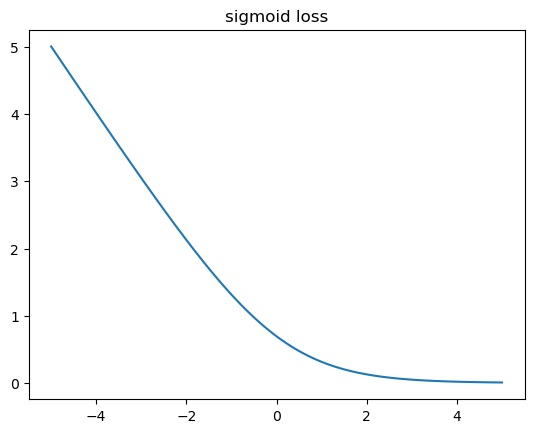

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(-5, 5.1, 0.1)
y1 = -np.log(1 / (1 + np.exp(-x)))
plt.plot(x, y1)
plt.title('sigmoid loss')
plt.show()

hinge:

$$l_{\text{hinge}} = \text{relu}(1 - \beta*\text{logits})$$

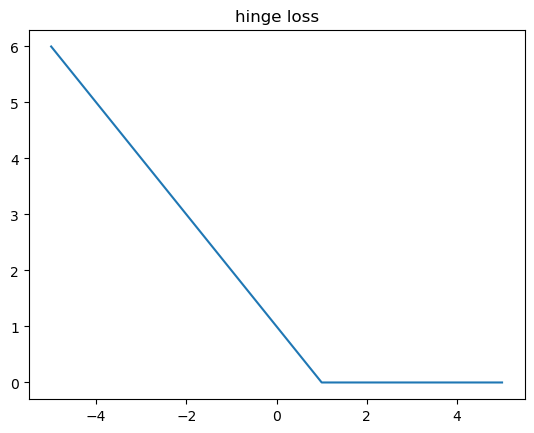

In [2]:
y2 = np.maximum(0, 1 - x)
plt.plot(x, y2)
plt.title('hinge loss')
plt.show()

ipo:

$$l_{\text{ipo}} = \left(\text{logits} - \frac{1}{2\beta}\right)^{2} = \frac{1}{\beta^{2}}\left(\beta\text{logits} - \frac{1}{2}\right)^{2}$$

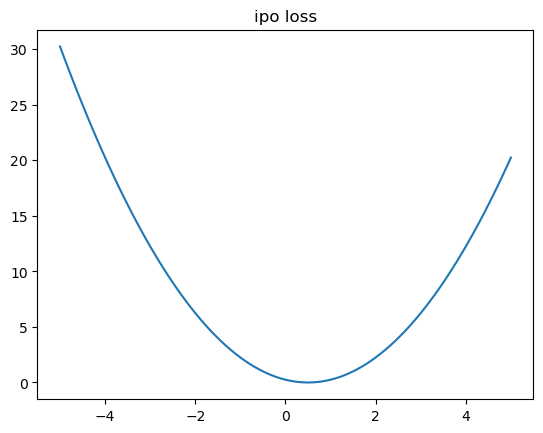

In [3]:
y3 = (x - 0.5) ** 2
plt.plot(x, y3)
plt.title('ipo loss')
plt.show()

## Appendix

### Derivation of $\pi_{r}$

The RL objective:

$$
\begin{aligned}
&\max_{\pi}\mathbb{E}_{x\sim\mathcal{D},y\sim\pi}\left[r(x, y)\right] - \beta\mathbb{D}_{\text{KL}}\left[\pi(y|x)\ ||\ \pi_{\text{ref}}(y|x)\right]\\
=&\max_{\pi}\mathbb{E}_{x\sim\mathcal{D},y\sim\pi}\left[r(x, y) - \beta\log\frac{\pi(y|x)}{\pi_{\text{ref}}(y|x)}\right]\\
=&\min_{\pi}\mathbb{E}_{x\sim\mathcal{D},y\sim\pi}\left[\log\frac{\pi(y|x)}{\pi_{\text{ref}}(y|x)} - \frac{1}{\beta}r(x, y)\right]\\
=&\min_{\pi}\mathbb{E}_{x\sim\mathcal{D},y\sim\pi}\left[\log\frac{\pi(y|x)}{\frac{1}{Z(x)}\pi_{\text{ref}}(y|x)\exp\left(\frac{1}{\beta}r(x, y)\right)} - \log Z(x)\right]
\end{aligned}
$$

where we have partition function:

$$Z(x) = \sum_{y}\pi_{\text{ref}}(y|x)\exp\left(\frac{1}{\beta}r(x, y)\right)$$

Note that the partition function is a function of only $x$ and the reference policy $\pi_{\text{ref}}$, but does not
depend on the policy $\pi$. We can now define

$$\pi^{\ast}(y|x)=\frac{1}{Z(x)}\pi_{\text{ref}}(y|x)\exp\left(\frac{1}{\beta}r(x,y)\right),$$

which is a valid probability distribution. Since $Z(x)$ is not a function of $y$, we can then re-organize the final objective as:

$$
\begin{aligned}
&\min_{\pi}\mathbb{E}_{x\sim\mathcal{D}}\left[\mathbb{E}_{y\sim\pi(y|x)}\left[\frac{\pi(y|x)}{\pi^{\ast}(y|x)}\right]  - \log Z(x)\right]\\
=&\min_{\pi}\mathbb{E}_{x\sim\mathcal{D}}\left[\mathbb{D}_{\text{KL}}(\pi(y|x)\ ||\ \pi^{\ast}(y|x)) - \log Z(x)\right]
\end{aligned}
$$

Now, since $Z(x)$ does not depend on $\pi$, the minimum is achieved by the policy that minimizes the
first KL term. Gibbs’ inequality tells us that the KL-divergence is minimized at 0 if and only if the
two distributions are identical. Hence we have the optimal solution:

$$\pi(y|x)=\pi^{\ast}(y|x) = \frac{1}{Z(x)}\pi_{\text{ref}}(y|x)\exp(\frac{1}{\beta}r(x, y))$$

for all $x\in\mathcal{D}$.

### Gradient of DPO Loss

$$
\begin{aligned}
\nabla_{\theta}\mathcal{L}_{\text{DPO}}(\pi_{\theta};\pi_{\text{ref}}) &= \nabla_{\theta}-\mathbb{E}_{(x, y_{w},y_{l})\sim\mathcal{D}}\left[\log\sigma\left(\beta\log\frac{\pi_{\theta}(y_{w}|x)}{\pi_{\text{ref}}(y_{w}|x)} -  \beta\log\frac{\pi_{\theta}(y_{l}|x)}{\pi_{\text{ref}}(y_{l}|x)}\right)\right]\\
&=-\mathbb{E}_{(x, y_{w},y_{l})\sim\mathcal{D}} \left[\frac{1}{\sigma(\psi)}\sigma(\psi)(1-\sigma(\psi))\beta\left(\nabla_{\theta}\log\frac{\pi_{\theta}(y_{w}|x)}{\pi_{\text{ref}}(y_{w}|x)} - \nabla_{\theta}\log\frac{\pi_{\theta}(y_{l}|x)}{\pi_{\text{ref}}(y_{l}|x)}\right)\right]\\
&=-\beta\mathbb{E}_{(x, y_{w},y_{l})\sim\mathcal{D}}\left[\sigma(\hat{r}_{\theta}(x, y_{l}) -\hat{r}_{\theta}(x, y_{w}))\left[\nabla_{\theta}\log\pi_{\theta}(y_{w}|x) - \nabla_{\theta}\log\pi_{\theta}(y_{l}|x)\right]\right]
\end{aligned}
$$

where $\hat{r}_{\theta}(x, y ) = \beta\log\frac{\pi_{\theta}(y|x)}{\pi_{\text{ref}}(y|x)}$ is the reward implicitly defined by the language model $\pi_{\theta}$ and reference model $\pi_{\text{ref}}$. Intuitively, the gradient of the loss function $\mathcal{L}_{\text{DPO}}$ increases the
likelihood of the preferred completions $y_{w}$ and decreases the likelihood of dispreferred completions $y_{l}$. Importantly, the examples are weighed by how incorrectly the implicit reward model orders
the completions. Our experiments suggest the
importance of this weighting, as a naive version of this method without the weighting coefficient can
cause the language model to degenerate.